# Data Exploration Project - Pumps

## Business Understanding

Daten über verschiedene Brunnen in einem afrikanischen Land.

**Können wir vorhersagen welche Brunnen defekt, wartungsbedürftig oder voll funktional sind?**

## Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

Einlesen der Trainings- und Testdaten.

In [2]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Data Analysis

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [3]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [4]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [5]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [6]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [7]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    # ("ord_enc", OrdinalEncoder()),
    ("scale", MinMaxScaler())
])

In [8]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [9]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add new feature manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
y_train_r = df_train["t_needs_rep"]

col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [10]:
X_train = col_trans.fit_transform(X=df_train, y=y_train)

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


## Modeling

- normal models
- pca
- balancing
- experiment with construction year

### a. Model Selection

In [11]:
df_results = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

#### LogisticRegression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

lr_cf = LogisticRegression(multi_class="ovr", max_iter=1000)
lr_cf.fit(X_train, y_train)
y_pred = lr_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=lr_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

In [13]:
df_results.loc[len(df_results)] = [lr_cf, auc_train, auc_cv]

#### SVM

In [14]:
from sklearn.svm import SVC
from tqdm import tqdm

svm_cf = SVC(probability=True, decision_function_shape="ovr")
svm_cf.fit(X_train, y_train)
y_pred = svm_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=svm_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv]


#### KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_cf = KNeighborsClassifier()
knn_cf.fit(X_train, y_train)
y_pred = knn_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=knn_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [knn_cf, auc_train, auc_cv]

#### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

dt_cf = DecisionTreeClassifier()
dt_cf.fit(X_train, y_train)
y_pred = dt_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=dt_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [dt_cf, auc_train, auc_cv]

#### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train, y_train)
y_pred = rf_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [str(rf_cf), auc_train, auc_cv]

#### XGBoost

In [17]:
from xgboost import XGBClassifier

xgb_cf = XGBClassifier()
xgb_cf.fit(X_train, y_train)
y_pred = xgb_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv]

In [18]:
df_results.to_csv("pm3_sel_results.csv")
df_results

,Model,AUC Train,AUC CV
0,"LogisticRegression(max_iter=1000, multi_class=...",0.869001,0.866267
1,KNeighborsClassifier(),0.957829,0.855479
2,DecisionTreeClassifier(),1.000000,0.751948
3,RandomForestClassifier(random_state=42),1.000000,0.902239
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.964362,0.925640


<AxesSubplot:>

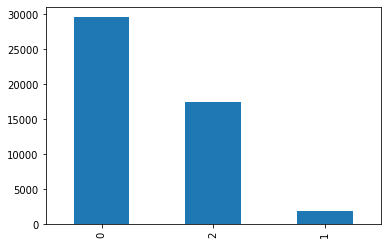

In [20]:
pd.Series(xgb_cf.predict(X_train)).value_counts().plot.bar()

### b. Hyperparameter Tuning

Gewählte Modelle:
- RandomForest
- XGBoost \
--> Bester CV-Score, trotzdem noch Overfitting, viele Hyperparameter zum Anpassen --> Ideal für Hyperparameter Tuning

In [23]:
df_tuned = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

#### Random Forest

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    "n_estimators":[100, 250, 500],
    "max_depth": [5, 10, 15, 20],
    "bootstrap": [True, False]
}]

rf_cf = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf_cf, param_grid=param_grid, scoring="roc_auc_ovr", cv=5)
gs.fit(X_train, y_train)
gs.best_params_

{'bootstrap': True, 'max_depth': 20, 'n_estimators': 500}

In [24]:
rf_cf = gs.best_estimator_

rf_cf.fit(X_train, y_train)
y_pred = rf_cf.predict_proba(X_train)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [str(rf_cf), auc_train, auc_cv]

KeyboardInterrupt: 

#### XGBoost

In [ ]:
param_grid = [{
    "n_estimators":[100, 250, 500],
    "max_depth": [5, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1]
}]

xgb_cf = XGBClassifier()
gs = GridSearchCV(xgb_cf, param_grid=param_grid, scoring="roc_auc_ovr", cv=5)
gs.fit(X_train, y_train)
gs.best_params_

In [ ]:
xgb_cf = gs.best_estimator_

xgb_cf.fit(X_train, y_train)
y_pred = xgb_cf.predict_proba(X_train)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [str(xgb_cf), auc_train, auc_cv]

In [ ]:
df_tuned.to_csv("pm3_tuned.csv")
df_tuned

## Evaluation

- Test Set
- ROC Visualization

In [ ]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_AUC(model, X_train, y_train, X_test, y_test):

    vis = ROCAUC(model, encoder={0: 'functional', 1: ' func_needs_rep', 2: 'non_functional'})
                                                                         
    vis.fit(X_train, y_train)
    vis.score(X_test, y_test)
    vis.show()
    
    return vis

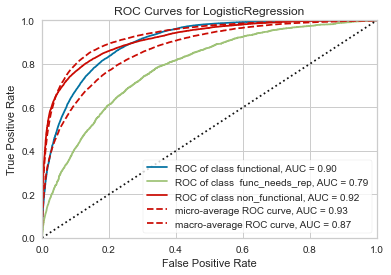

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'functional', 1: ' func_needs_rep', 2: 'non_functional'},
       estimator=LogisticRegression(max_iter=1000, multi_class='ovr'))

In [ ]:
plot_ROC_AUC(lr_cf, X_train, y_train, X_train, y_train) # just an example